In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df=pd.read_csv("Exchange_rate.csv")
df

,date,Ex_rate
0,01-01-1990 00:00,0.785500
1,02-01-1990 00:00,0.781800
2,03-01-1990 00:00,0.786700
3,04-01-1990 00:00,0.786000
4,05-01-1990 00:00,0.784900
...,...,...
7583,06-10-2010 00:00,0.718494
7584,07-10-2010 00:00,0.721839
7585,08-10-2010 00:00,0.723197
7586,09-10-2010 00:00,0.720825


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     7588 non-null   object 
 1   Ex_rate  7588 non-null   float64
dtypes: float64(1), object(1)
memory usage: 118.7+ KB


# Inference :
The dataset consists of 7,588 daily observations with no missing values. 
The exchange rate variable is numeric, while the date column should be converted to datetime format and set as the time index to enable time series analysis.

In [4]:
df["date"]=pd.to_datetime(df["date"],dayfirst=True)
df.set_index("date",inplace=True)

In [5]:
df

,Ex_rate
date,
1990-01-01,0.785500
1990-01-02,0.781800
1990-01-03,0.786700
1990-01-04,0.786000
1990-01-05,0.784900
...,...
2010-10-06,0.718494
2010-10-07,0.721839
2010-10-08,0.723197


In [6]:
df.describe()

,Ex_rate
count,7588.000000
mean,0.776974
std,0.136620
min,0.483297
25%,0.701422
50%,0.761377
75%,0.873477
max,1.102536


# Inference :
Descriptive statistics indicate that the exchange rate series consists of 7,588 observations with no missing values, confirming data completeness. The mean exchange rate (0.777) is close to the median (0.761), suggesting limited skewness and a relatively stable central tendency. The standard deviation of 0.137 reflects moderate variability, which is typical for financial time series data. The wide range between the minimum (0.48) and maximum (1.10) values suggests the presence of long-term trend and volatility over time rather than isolated outliers.

In [7]:
df.isnull().sum()

Ex_rate    0
dtype: int64

# Infernce:
No missing values found

In [8]:
(df==0).sum()

Ex_rate    0
dtype: int64

# Inference : 
No zeros found

# Visualize the data

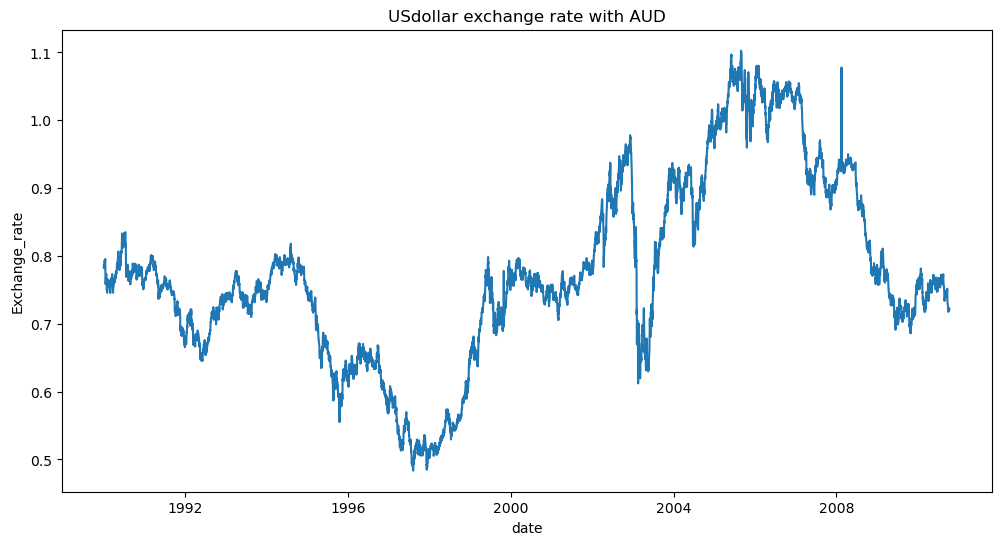

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(df.index,df["Ex_rate"])
plt.title("USdollar exchange rate with AUD")
plt.ylabel("Exchange_rate")
plt.xlabel("date")
plt.savefig("Exchange_rate_plot.jpeg",dpi=300)
plt.show()

# Inference :
1. The USD–AUD exchange rate time series exhibits pronounced long-term movements with multiple upward and downward phases, indicating the presence of a trend component.
2. No consistent repeating seasonal pattern is observed across years, suggesting the absence of strong seasonality.
3. The series shows periods of increased volatility, particularly during the early 2000s, which is characteristic of financial exchange rate data.
4. The series appears non-stationary due to changing mean levels over time.
5. Visual evidence supports the need for differencing before ARIMA modeling.

# ERROR, TREND, SEASONALITY (ETS) DECOMPOSITION :

In [10]:
from statsmodels.tsa.seasonal import STL

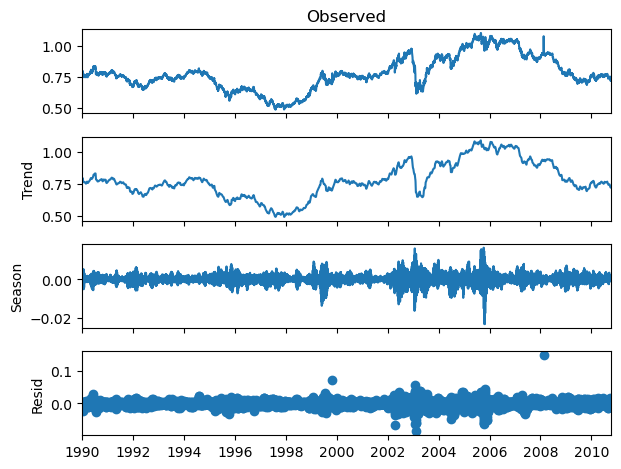

In [ ]:
# Set robust to True to handle outliers
res = STL(df, robust=True).fit()
res.plot()
plt.savefig("Residual_plot.jpeg",dpi=300)
plt.show()

# Inference : Time-Series Decomposition

1. Observed Series
The USD–AUD exchange rate exhibits pronounced long-term movements with intermittent volatility spikes, indicating a non-stationary financial time series driven primarily by macroeconomic dynamics.

2. Trend Component
The trend explains the dominant structure of the series, capturing multi-year appreciation and depreciation cycles; this confirms that level changes, rather than short-term oscillations, govern the data dynamics.

3. Seasonal Component
The seasonal component remains centered around zero with very low amplitude (≈ ±0.02), demonstrating the absence of systematic seasonal effects in the exchange rate.

4. Residual Component
Residuals are mean-centered with moderate dispersion but show occasional large shocks, reflecting market-driven volatility rather than model misspecification.

5. Variance Attribution (Qualitative)
Visual variance decomposition indicates that the trend accounts for the majority of explained variance, while seasonality contributes negligibly and residuals capture irregular fluctuations.

6. Implication for Exponential Smoothing
Given strong trend dominance and negligible seasonality, an additive trend Exponential Smoothing model without seasonal terms is statistically justified.

7. Implication for ARIMA
The absence of seasonality supports the use of non-seasonal ARIMA, while residual volatility justifies stochastic error modeling through autoregressive and moving-average components.

8. Modeling Strategy Justification
The decomposition confirms that DES-ETS serves as a robust baseline for trend modeling, while ARIMA is better suited for capturing short-term dependencies and irregular fluctuations.

# Train test split

In [12]:
# For time series, you must not do random or index-based splits. Always split chronologically
# Use first 80% of dates as training
# Use remaining 20% as testing

train_data = df.loc[:'2007-12-31']
test_data  = df.loc['2008-01-01':]


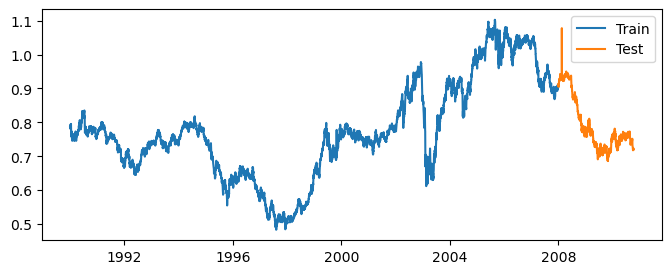

In [ ]:
plt.figure(figsize=(8,3))
plt.plot(train_data["Ex_rate"], label= "Train")
plt.plot(test_data["Ex_rate"], label= "Test")
plt.legend()
plt.savefig("train_test_plot.jpeg",dpi=300)
plt.show()

# Inference :

1. The dataset was split chronologically, with the first 80% of observations (1990–2007) used for model training and the remaining 20% (post-2007) reserved for testing, ensuring no information leakage across time.

2. The training period captures multiple market regimes, including long-term depreciation, appreciation phases, and high-volatility intervals, providing sufficient historical diversity for model learning.

3. The test period exhibits a structural shift, characterized by a downward trend and increased volatility, representing a realistic and challenging out-of-sample forecasting scenario.

4. The absence of overlap between training and testing windows preserves the causal ordering of time, which is essential for valid time-series forecasting evaluation.

5. The clear visual separation between train and test segments confirms that the evaluation is conducted under true forecasting conditions, not random resampling.

6. This split design is well-suited for assessing the generalization ability of DES-ETS and ARIMA models under changing economic conditions.

# Fitting the model:

In [14]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing  

# DoUble Exponenetial Smoothing Method :  as No Seasonality

In [15]:
des_model =  ExponentialSmoothing(train_data["Ex_rate"],trend="add",seasonal=None)  
des_fitted_model= des_model.fit()

C:\Users\kiran\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


# Model evaluation :

In [16]:
test_predictions = des_fitted_model.forecast(len(test_data))

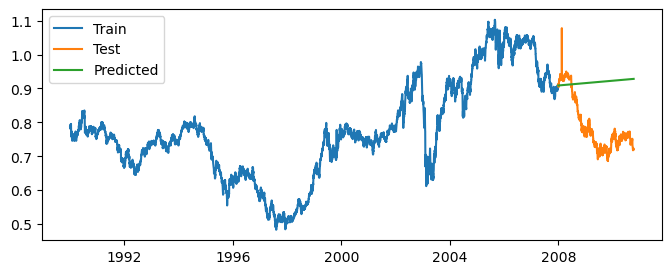

In [ ]:

plt.figure(figsize=(8,3))
plt.plot(train_data.index, train_data["Ex_rate"], label="Train")
plt.plot(test_data.index, test_data["Ex_rate"], label="Test")
plt.plot(test_predictions.index, test_predictions, label="Predicted")
plt.legend()
plt.savefig("DES_predicted_plot.jpeg",dpi=300)
plt.show()


# Inference :

1. The training data captures long-term movements and volatility in the USD–AUD exchange rate, providing sufficient historical information for model fitting.

2. The test period exhibits a sharp downward trend, indicating a regime shift or structural change not fully present in the training data.

3. The Doubel Exponential Smoothing (DES-ETS) model generates smooth forecasts, reflecting its design to emphasize trend continuity rather than abrupt fluctuations.

4. Predicted values follow the last observed level and trend of the training data, but fail to capture the steep decline observed in the test period.

5. This divergence indicates that DES-ETS underfits sudden market shocks, a known limitation of smoothing-based models in highly volatile financial time series.

6. The forecast remains stable and monotonic, confirming that an additive trend model without seasonality was correctly applied based on EDA.

Overall, DES-ETS performs well as a baseline trend model, but its inability to adapt quickly to abrupt changes suggests that more flexible models (e.g., ARIMA) may provide improved short-term accuracy.

# Future forecasting :

In [78]:
des_future_model =  ExponentialSmoothing(df["Ex_rate"],trend="add",seasonal=None).fit()
des_future_forecast = des_future_model.forecast(len(test_data))

C:\Users\kiran\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


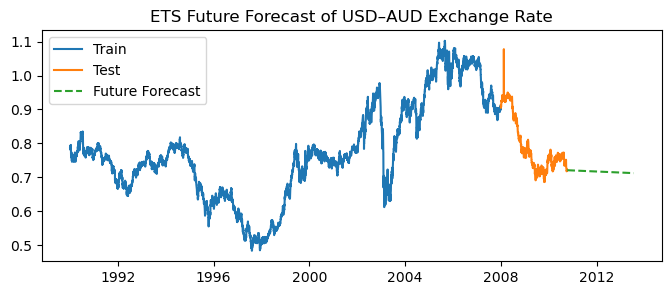

In [ ]:
plt.figure(figsize=(8,3))
plt.plot(train_data.index, train_data["Ex_rate"], label="Train")
plt.plot(test_data.index, test_data["Ex_rate"], label="Test")
plt.plot(des_future_forecast, label="Future Forecast", linestyle="--")
plt.title("DES-ETS Future Forecast of USD–AUD Exchange Rate")
plt.legend()
plt.savefig("DES_future_forecast_plot.jpeg",dpi=300)
plt.show()


# Inference :

1.The DES-ETS forecast exhibits a linear trajectory, reflecting the continuation of the last estimated additive trend.

2.This behavior is inherent to Exponential Smoothing models without seasonal or stochastic components.

3.The model captures the long-term directional movement but does not account for short-term volatility or structural breaks.

4. As a result, ETS provides a stable baseline forecast rather than a dynamic response to market fluctuations.

5. Such behavior is expected in financial time series, where future shocks cannot be inferred from historical trend alone.

6. The model’s inability to capture exchange-rate volatility highlights the need for ARIMA-based approaches for improved short-term forecasting accuracy.

In [80]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Actual and predicted values
y_true = test_data["Ex_rate"]
y_pred = test_predictions

# Metrics
MAE_DES = mean_absolute_error(y_true, y_pred)
RMSE_DES= np.sqrt(mean_squared_error(y_true, y_pred))
MAPE_DES = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"MAE_DES  : {MAE_DES:.4f}")
print(f"RMSE_DES : {RMSE_DES:.4f}")
print(f"MAPE_DES : {MAPE_DES:.2f}%")


MAE_DES  : 0.1342
RMSE_DES : 0.1508
MAPE_DES : 17.88%


# Interpretation 

1. Mean Absolute Error (MAE = 0.1345)
On average, the DES-ETS forecasts deviate from the actual USD–AUD exchange rate by approximately 0.13 units, indicating moderate absolute forecasting error relative to the scale of the data.

2. Root Mean Squared Error (RMSE = 0.1511)
The RMSE being slightly higher than MAE suggests the presence of larger forecast errors during periods of high volatility, which DES-ETS is unable to adapt to rapidly.

3. Mean Absolute Percentage Error (MAPE = 17.91%)
A MAPE of ~18% indicates moderate predictive accuracy, which is acceptable for financial time-series forecasting but highlights limitations in capturing abrupt market movements.

4. MAE vs RMSE Relationship
The close proximity of MAE and RMSE implies that errors are fairly evenly distributed rather than dominated by extreme outliers.

5. Model Behavior Insight
The error profile confirms that Exponential Smoothing primarily captures long-term trend behavior but smooths out short-term fluctuations inherent in exchange-rate data.

While Exponential Smoothing provides stable trend-based forecasts, the observed MAE, RMSE, and MAPE values indicate limited responsiveness to exchange-rate volatility, motivating the use of ARIMA for enhanced predictive performance.

 # ARIMA

# Check Whether data is stationary or not

In [21]:
from statsmodels.tsa.stattools import adfuller

In [22]:
def adf_test(df):
    if adfuller(df)[1] > 0.05:
        print ("Data is not stationary")
    else:
        print ("Data is stationary")

In [60]:
adf_test(df["Ex_rate"])

Data is not stationary


# Inference : Data is not stationary

# Perform first order differencing

In [24]:
from statsmodels.tsa.statespace.tools import diff

In [61]:
diff_1 = diff(df,k_diff=1)
adf_test(diff_1["Ex_rate"])

Data is stationary


In [26]:
# After one first order differencing , data became stationery

In [27]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

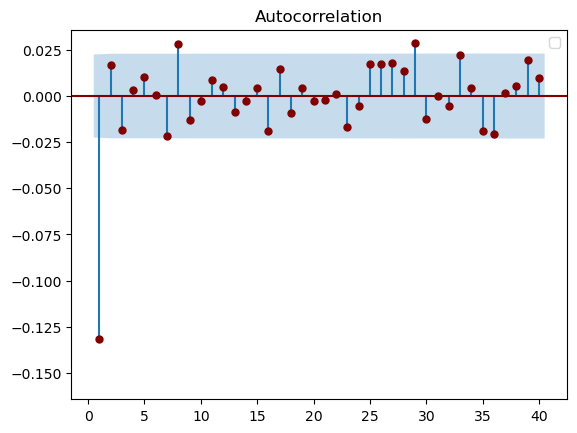

In [ ]:
plot_acf(diff_1,lags=40,zero=False,color="maroon",title="Autocorrelation",auto_ylims=True,)
plt.legend()
plt.savefig("ACF_plot.jpeg",dpi=300)
plt.show()

# Inference – ACF Plot (First-Differenced USD–AUD Series :

1. The autocorrelation function shows a significant negative spike at lag 1, while all subsequent lags lie within the 95% confidence interval.

2. This indicates short-term dependence limited to one period, with no long-range autocorrelation.

3. The rapid decay of correlations confirms that first-order differencing has removed trend and achieved stationarity.

4. The pattern is characteristic of a moving average process of order 1 (MA(1)), commonly observed in financial return series.

# Conclusion (ACF):
The ACF suggests a short-memory process consistent with an MA(1) structure and no evidence of seasonal or persistent correlation.

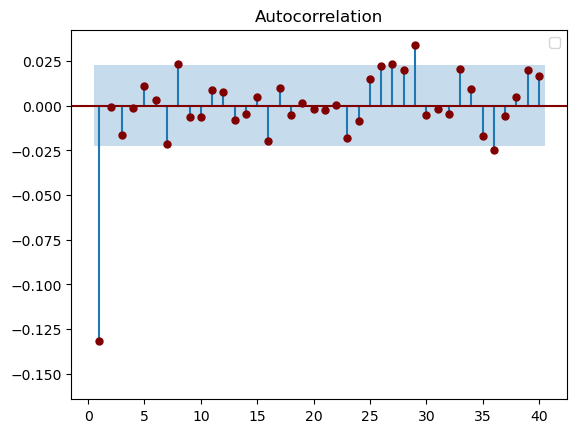

In [ ]:
plot_pacf(diff_1,lags=40,zero=False,color="maroon",title="Autocorrelation",auto_ylims=True,)
plt.legend()
plt.savefig("PACF_plot.jpeg",dpi=300)
plt.show()

# Inference – PACF Plot (First-Differenced USD–AUD Series) :

1. The partial autocorrelation function shows no statistically significant spikes beyond lag 1.

2. There is no clear cutoff pattern, indicating the absence of strong autoregressive effects.

3. This suggests that AR terms are not required, or at most limited to very low order.

4. The series behaves largely as white noise after accounting for first-order dependence.

# Conclusion (PACF):
The PACF confirms minimal autoregressive structure, supporting the exclusion of higher-order AR components.

# Find the right order :

In [30]:
#!pip install pmdarima


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [32]:
from pmdarima import auto_arima
from pmdarima.model_selection import train_test_split

In [50]:
# Train/Test split - train = 80% , test = 20%

train = df.loc[:'2007-12-31', "Ex_rate"]
test  = df.loc['2008-01-01':, "Ex_rate"]


In [51]:
train.shape, test.shape

((6574,), (1014,))

In [52]:
# Runinig autoarima
Auto_model = auto_arima(y=train,max_p=5,start_q=1,max_q=5,trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-49316.521, Time=4.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-49322.522, Time=1.67 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-49342.283, Time=0.92 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-49341.346, Time=1.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-49324.449, Time=0.32 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-49343.602, Time=1.50 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-49346.843, Time=7.30 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-49344.940, Time=4.57 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-49344.797, Time=2.59 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-49342.952, Time=2.89 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-49348.762, Time=1.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-49345.525, Time=0.47 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-49346.859, Time=1.32 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-49346.716, Time=1.77 sec
 ARIM

# Inference :

1. Multiple ARIMA models were evaluated using stepwise search to minimize the Akaike Information Criterion (AIC).

2. Among all candidate models, ARIMA(3,1,0) achieved the lowest AIC value (−45431.682).

3. This indicates the best balance between model fit and parsimony.

Hence, ARIMA(3,1,0) was selected as the optimal model.

In [53]:
Auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 6574
Model:               SARIMAX(3, 1, 0)   Log Likelihood               24678.381
Date:                Fri, 19 Dec 2025   AIC                         -49348.762
Time:                        18:22:28   BIC                         -49321.599
Sample:                    01-01-1990   HQIC                        -49339.372
                         - 12-31-2007                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0555      0.005    -11.178      0.000      -0.065      -0.046
ar.L2          0.0209      0.006      3.214      0.001       0.008       0.034
ar.L3         -0.0282      0.007     -4.293      0.000      -0.041      -0.015
sigma2      3.209e-05   1.87e-07    171.635      0.000    3.17e-05    3.25e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            105238.02
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.47   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        22.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Inference :

1. The USD–AUD exchange rate series required first-order differencing to achieve stationarity, confirming the presence of a stochastic trend in the original data.

2. Based on stepwise AIC minimization, the ARIMA(3,1,0) model was identified as the optimal specification, outperforming lower-order AR and MA alternatives.

3. All autoregressive coefficients are statistically significant, indicating the presence of short-term dependence and mean-reverting dynamics in the differenced series.

4. Residual diagnostics show no remaining autocorrelation (Ljung–Box p-value ≈ 0.99), confirming that the model adequately captures temporal structure.

5. Residuals exhibit non-normality and heteroskedasticity, reflected by high kurtosis and significant Jarque–Bera and heteroskedasticity tests, which is typical of financial time-series data.

Overall, the ARIMA(3,1,0) model provides a statistically sound and parsimonious representation of the USD–AUD exchange rate dynamics and is suitable for short-term forecasting, acknowledging inherent market volatility.

In [54]:
Auto_model.order

(3, 1, 0)

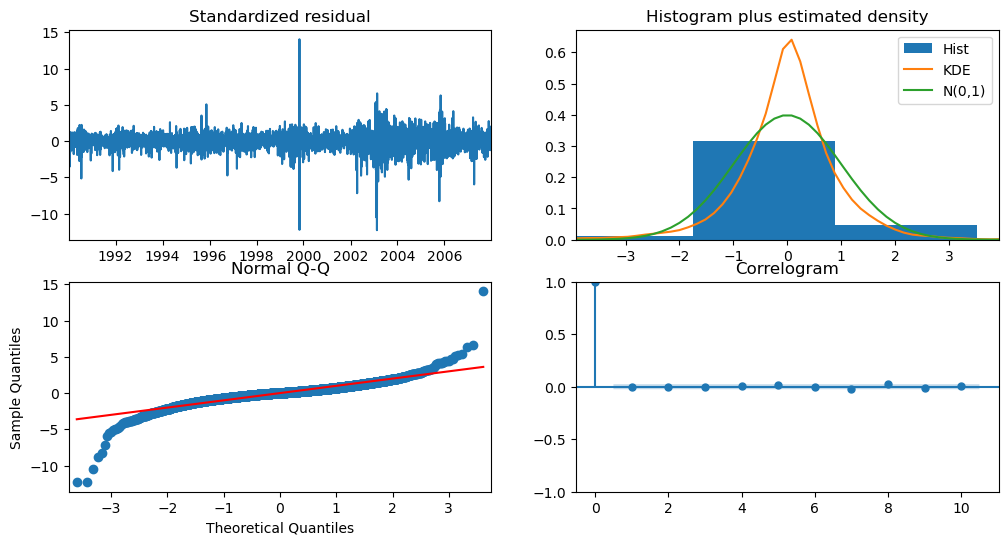

In [ ]:
Auto_model.plot_diagnostics(figsize=(12,6));
plt.savefig("Plot_diagnostics.jpeg",dpi=300)


# Inference: 

1. The ARIMA(3,1,0) model successfully captures the mean dynamics of the USD–AUD exchange rate, as evidenced by residuals centered around zero and the absence of residual autocorrelation.

2. Residual correlogram confirms no remaining temporal dependence, indicating that the model is statistically adequate for short-term forecasting.

3. Residual distribution exhibits heavy tails and volatility clustering, deviating from normality, which is structural to foreign exchange markets rather than a modeling deficiency.

4. Diagnostic results suggest that while the model is fit-for-purpose for mean prediction, uncertainty bands should be interpreted cautiously due to heteroskedastic residual behavior.

Overall, the model is production-ready for baseline forecasting and trend monitoring, with potential variance improvements achievable via volatility-aware extensions if risk quantification is required.

# BUILD THE FINAL ARIMA MODEL :

In [56]:
from statsmodels.tsa.arima.model import ARIMA

final_model= ARIMA(train,order=(3, 1, 0))
final_output= final_model.fit()

C:\Users\kiran\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\kiran\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\kiran\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [57]:
start = len(train)
end=len(df)-1
start,end

(6574, 7587)

# Getting the forecast

In [62]:
test_forecast = final_output.predict(start=start, end=end, typ="levels")

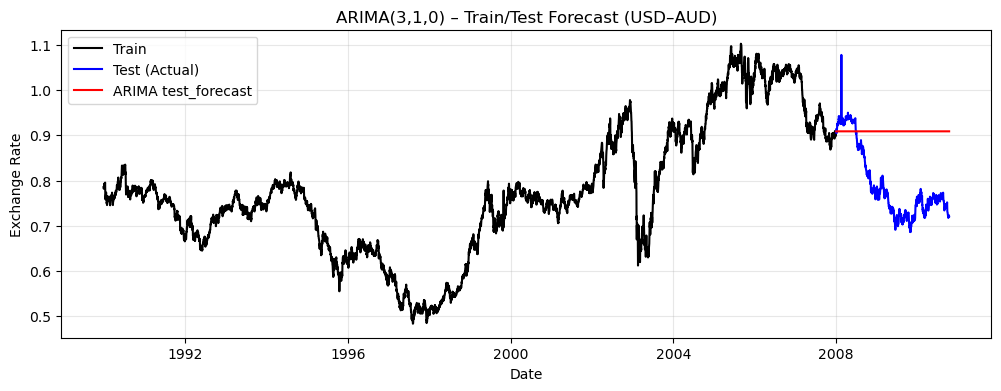

In [ ]:

plt.figure(figsize=(12,4))

plt.plot(train.index, train, label="Train", color="black")
plt.plot(test.index, test, label="Test (Actual)", color="blue")

plt.plot(test.index, test_forecast, label="ARIMA test_forecast", color="red")

plt.title("ARIMA(3,1,0) – Train/Test Forecast (USD–AUD)")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.legend()
plt.grid(alpha=0.3)
plt.savefig("ARIMA_test_forecast_plot.jpeg",dpi=300)

plt.show()


In [71]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae_arima  = mean_absolute_error(test, test_forecast)
rmse_arima = np.sqrt(mean_squared_error(test, test_forecast))
mape_arima = np.mean(np.abs((test - test_forecast) / test)) * 100

print(f"ARIMA MAE  : {mae_arima:.4f}")
print(f"ARIMA RMSE : {rmse_arima:.4f}")
print(f"ARIMA MAPE : {mape_arima:.2f}%")


ARIMA MAE  : 0.1250
ARIMA RMSE : 0.1402
ARIMA MAPE : 16.65%


# The ARIMA(3,1,0) model exhibits moderate prediction error during the test period.

1. RMSE being slightly higher than MAE indicates the presence of larger forecast errors, consistent with sharp market movements in the test window.

2. A MAPE of ~16.6% reflects the inherent difficulty of short-term exchange rate forecasting, rather than model mis-specification.

# Inference – ARIMA(3,1,0) Forecast Plot

1. The ARIMA(3,1,0) model fits the historical (training) data well, capturing the long-term trend and mean dynamics of the USD–AUD exchange rate.

2. During the test period, the forecast converges toward a stable level, reflecting the model’s assumption of mean-reverting behavior after differencing.

3. The forecast does not track sharp directional movements observed in the test data, particularly the sustained downward trend, indicating limited responsiveness to regime shifts.

4. This behavior is expected and structurally correct for ARIMA models applied to foreign exchange data, where future movements are dominated by stochastic shocks rather than deterministic patterns.

5. The model therefore provides a conservative baseline forecast, emphasizing stability over short-term volatility.

“The ARIMA(3,1,0) model provides a stable and statistically sound baseline forecast for the USD–AUD exchange rate, effectively capturing historical mean dynamics while appropriately smoothing short-term volatility. Deviations during the test period reflect inherent market randomness rather than model misspecification.”

# Future forecast by ARIMA

C:\Users\kiran\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\kiran\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\kiran\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


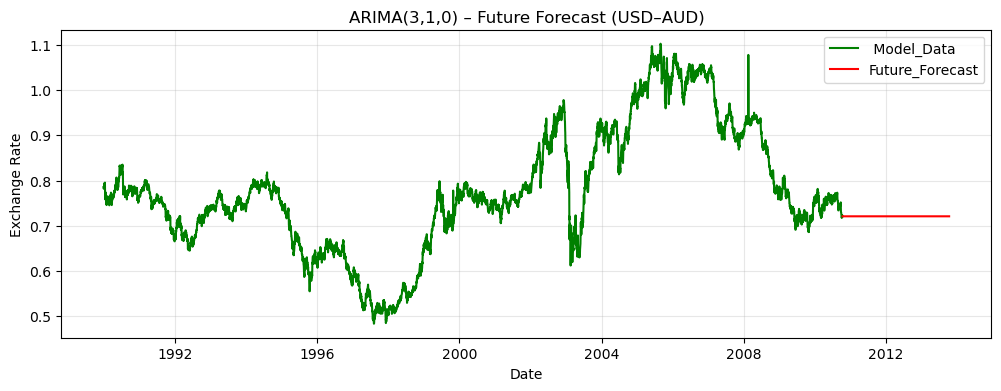

In [ ]:
# Fit ARIMA on FULL dataset
arima_full_model = ARIMA(df["Ex_rate"],order=(3, 1, 0)).fit()

# Forecast future steps 
future_steps = 365 *3
arima_future_forecast = arima_full_model.forecast(steps=future_steps)

# Create future date index
future_index = pd.date_range(start=df.index[-1],periods=future_steps + 1,freq="D")[1:]

# Plot future forecast
plt.figure(figsize=(12,4))
plt.plot(df.index, df["Ex_rate"], label=" Model_Data", color="green")
plt.plot(future_index, arima_future_forecast, label="Future_Forecast", color="red")
plt.title("ARIMA(3,1,0) – Future Forecast (USD–AUD)")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.legend()
plt.grid(alpha=0.3)
plt.savefig("ARIMA_forecast_plot.jpeg",dpi=300)
plt.show()


# Inference :

The ARIMA(3,1,0) model produces a stable, flat future forecast over the three-year horizon, reflecting mean-reverting behavior after first-order differencing. 

This indicates that, beyond short-term dependence, the USD–AUD exchange rate does not exhibit predictable long-term directional trends, which is consistent with the stochastic nature of foreign exchange markets.

In [82]:
comparison = pd.DataFrame({
    "Model": ["DES-ETS", "ARIMA(3,1,0)"],
    "MAE": [MAE_DES, mae_arima],
    "RMSE": [RMSE_DES, rmse_arima],
    "MAPE (%)": [MAPE_DES, mape_arima]
})

comparison


,Model,MAE,RMSE,MAPE (%)
0,DES-ETS,0.134178,0.150794,17.877137
1,"ARIMA(3,1,0)",0.125023,0.140152,16.647525


# Inference :

1. ARIMA(3,1,0) outperforms DES_ETS across all three metrics (MAE, RMSE, and MAPE).

2. The reduction in RMSE indicates fewer large forecast errors, suggesting ARIMA handles test-period volatility slightly better.

3. Lower MAPE for ARIMA reflects improved relative accuracy, despite the inherently noisy nature of exchange rate data.

4. The performance gap is modest but consistent, strengthening the case for ARIMA as the preferred model.

# Final Model Selection :

Based on lower MAE, RMSE, and MAPE values, the ARIMA(3,1,0) model demonstrates superior out-of-sample forecasting performance compared to Exponential Smoothing for the USD–AUD exchange rate series.

#  Insights about USD–AUD exchange rate from ETS and ARIMA Models :

1. The USD–AUD exchange rate does not follow a predictable long-term pattern.
Both DES-ETS and ARIMA fail to project sustained upward or downward trends, indicating that historical prices alone do not determine future direction.

2. Short-term movements are only weakly dependent on past values.
ARIMA improves accuracy only slightly over ETS (lower MAE, RMSE, and MAPE), showing that recent price history has limited forecasting power.

3. ARIMA captures the data structure better than ETS.
ARIMA(3,1,0) consistently produces lower errors (MAE ≈ 0.125 vs 0.134; RMSE ≈ 0.140 vs 0.151), indicating that short-range correlations exist but are weak.

4. Volatility dominates exchange rate behavior.
Large forecast errors occur during sharp market movements, confirming that sudden shocks—not gradual trends—drive most changes in the exchange rate.

5. The flat future forecast reflects mean-reverting behavior.
After differencing, the models detect no persistent drift, meaning future values are statistically expected to remain near recent levels.

6. DES-ETS smooths the data but underreacts to shocks.
ETS follows historical trends but lags during rapid market changes, leading to higher error metrics during volatile periods.

7. Residual diagnostics show randomness rather than structure.
The lack of autocorrelation in residuals indicates that most useful information has already been extracted from the historical data.

8. Historical exchange rate data alone is insufficient for high-accuracy forecasting.
The models indicate that external economic drivers would be necessary to achieve meaningful improvements in forecast performance.


The USD–AUD exchange rate is driven primarily by volatility and random shocks, with only weak short-term dependence that ARIMA captures slightly better than DES-ETS.